In [2]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline

In [55]:
class blackjack_game(gym.Env):
    def __init__(self):
        self.cards = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.action_space = spaces.Discrete(2)
        self.obs_space = spaces.Tuple((
                        spaces.Discrete(32),
                        spaces.Discrete(11),
                        spaces.Discrete(2)))
        self._seed()
        self._reset()
        self.nA = 2
    
    def ace_is_usable(self, cards):
        if 1 in cards:
            if sum(cards) + 10 <= 21:
                return 1
        else:
            return 0
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def _step(self, action):
        if action:
            self.player_cards.append(self.draw_card())
            if self.went_bust(self.player_cards):
                episode_over = True
                reward = -1
            else:
                episode_over = False
                reward = 0
        else:
            episode_over = True
            while self.player_total(self.dealer_cards) < 17:
                self.dealer_cards.append(self.draw_card())
            reward = int(self.hand_reward(self.player_cards) > self.hand_reward(self.dealer_cards)) - int(self.hand_reward(self.player_cards) < self.hand_reward(self.dealer_cards))
        return self.observations(), reward, episode_over, {}
    
    def observations(self):
        return(self.player_total(self.player_cards), self.dealer_cards[0], self.ace_is_usable(self.player_cards))
    
    def _reset(self):
        self.player_cards = self.get_hand()
        self.dealer_cards = self.get_hand()
        
        while self.player_total(self.player_cards) < 12:
            self.player_cards.append(self.draw_card())
        
        return self.observations()
        
    def get_hand(self):
        return [self.draw_card(), self.draw_card()]
      
    def hand_reward(self, player_cards):
        if self.went_bust(player_cards) is 1:
            return 0
        else:
            return self.player_total(player_cards)
    
    def went_bust(self, player_cards):
        return self.player_total(player_cards) > 21
    
    def player_total(self, player_cards):
        if self.ace_is_usable(player_cards):
            return np.sum(player_cards) + 10
        else:
            return np.sum(player_cards)
    
    def draw_card(self):
        return self.np_random.choice(self.cards)
    
    def render(self, player_action):
        arr = np.array(['Player points: ', self.player_total(self.player_cards), 'Player action: ', player_action, 
                        'Dealer points: ', self.player_total(self.dealer_cards), 'Dealer action: ', int(self.player_total(self.dealer_cards) < 17)])
        arr = arr.reshape((2,4))
        return arr

In [56]:
game = blackjack_game()

In [5]:
policy = lambda x: 1 - int(x >= 20)

In [82]:
class monte_carlo:
    def __init__(self, num_states, environment, gamma):
        self.num_states = num_states
        self.env = environment()
        self.gamma = gamma
    
    def find_first_visit(self, state, states):
        for i in range(len(states)):
            if states[i] == state:
                return i

    def generate_episode(self, policy, time_steps):
        episode, state = [], self.env._reset()
        for time_step in range(time_steps):
            action_choice = policy(state[0])
            new_state, reward, over, _ = self.env._step(action_choice)
            episode.append([state, action_choice, reward])
            if over:
                break
            state = new_state
        return episode
    
    def get_control_episode(self, time_steps, Q_, epsilon):
        episode, state = [], self.env._reset()
        policy = self.make_policy(Q_, epsilon, self.env.action_space.n)
        for time_step in range(time_steps):
            pi = policy(state)
            action_choice = np.random.choice(np.arange(len(pi)), p=pi)
            new_state, reward, over, _ = self.env._step(action_choice)
            episode.append([state, action_choice, reward])
            if over:
                break
            state = new_state
        return episode, policy
    
    def first_visit_MC_prediction(self, policy, epochs):
        V_ = defaultdict(float)
        returns = defaultdict(float)
        count = defaultdict(float)
        
        for ep in range(epochs):
            episode = self.generate_episode(policy, 1000)
            states = [tuple(x[0]) for x in episode]
            for state in states:
                first = self.find_first_visit(state, states)
                G = sum([x[2]*(self.gamma**i) for i,x in enumerate(episode[first:])])
                returns[state] += G
                count[state] += 1
                V_[state] = returns[state] / count[state]
        return V_
    
    def make_policy(self, Q_, epsilon, num_actions):
        def policy(obs):
            pi = np.ones(num_actions, dtype=float) * epsilon / num_actions
            optimal_action = np.argmax(Q_[obs])
            pi[optimal_action] += 1 - epsilon
            return pi
        return policy
    
    def state_action_MC_control(self, epochs, epsilon):
        Q_ = defaultdict(lambda: np.ones(self.env.action_space.n))
        returns = defaultdict(float)
        count = defaultdict(float)
        
        for ep in range(epochs):
            episode, pi = self.get_control_episode(1000, Q_, epsilon)
            states = [(x[0], x[1]) for x in episode]
            for state, action in states:
                state_action = (state, action)
                first = self.find_first_visit(state_action, states)
                G = sum([x[2]*(self.gamma**i) for i,x in enumerate(episode[first:])])
                returns[state_action] += G
                count[state_action] += 1
                Q_[state][action] = returns[state_action] / count[state_action]
        return Q_, pi

In [83]:
mc = monte_carlo(200, blackjack_game, 1)

In [75]:
val_func = mc.first_visit_MC_prediction(policy, 10000)

In [9]:
# plot_value_function exclusive credit to Denny Britz
import matplotlib
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

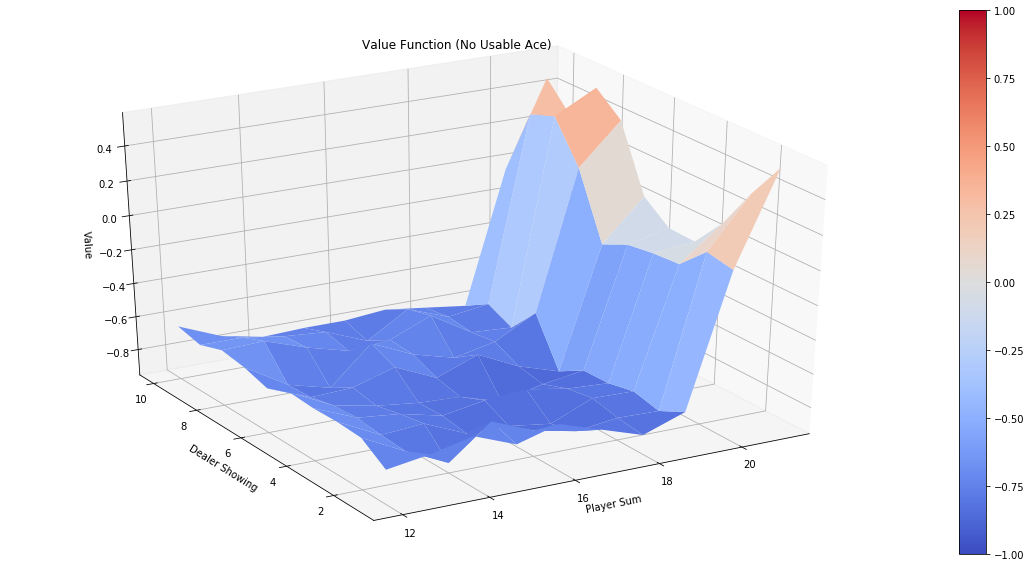

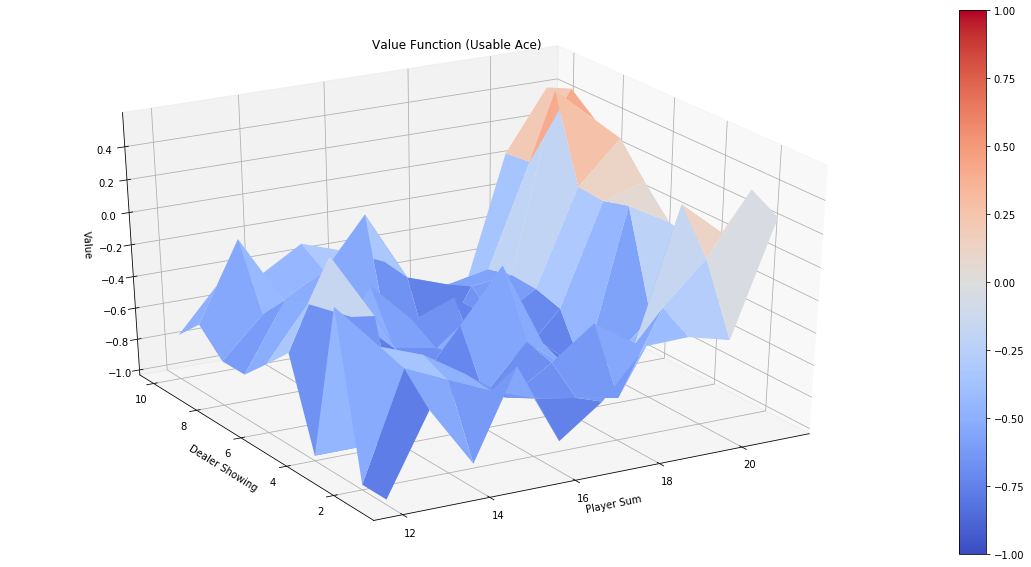

In [10]:
plot_value_function(val_func)

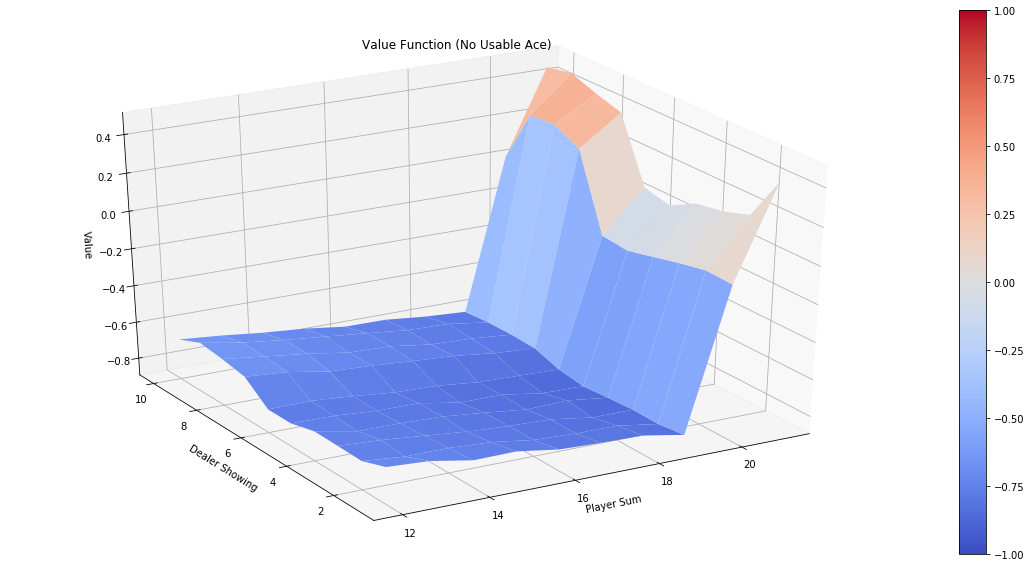

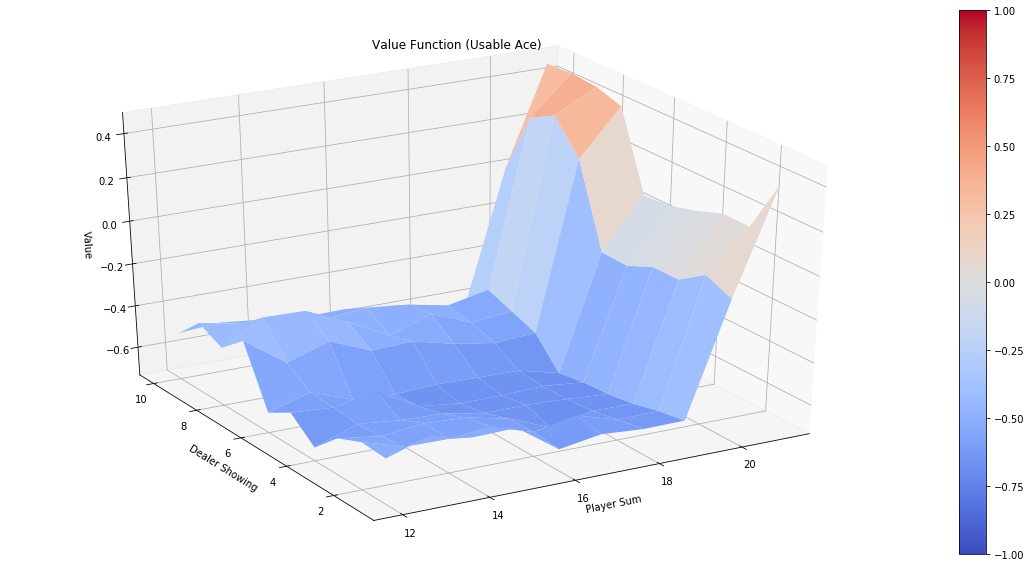

In [11]:
val_func_500 = mc.first_visit_MC_prediction(policy, 500000)
plot_value_function(val_func_500)

In [78]:
q, policy_ = mc.state_action_MC_control(500000, .1)

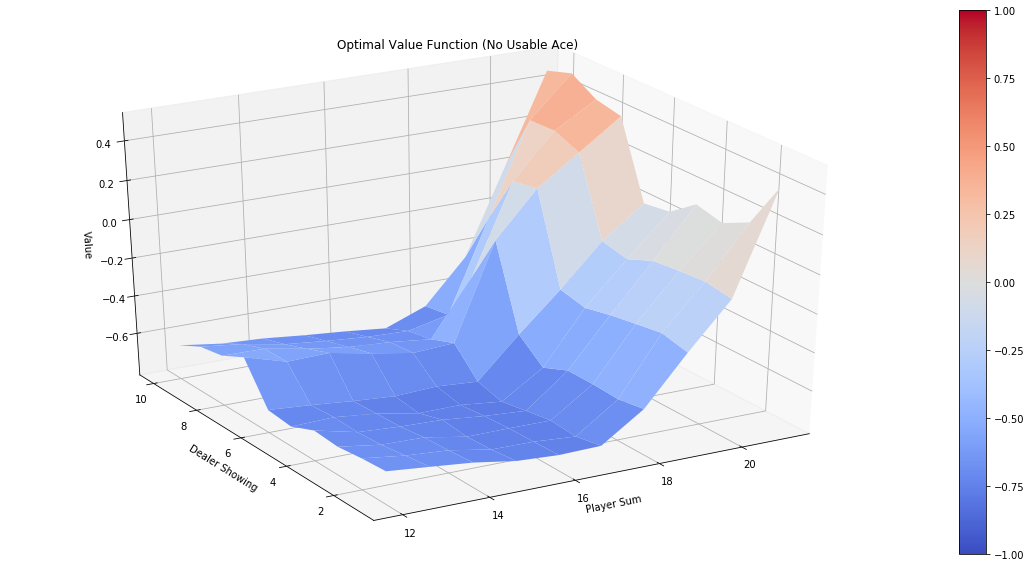

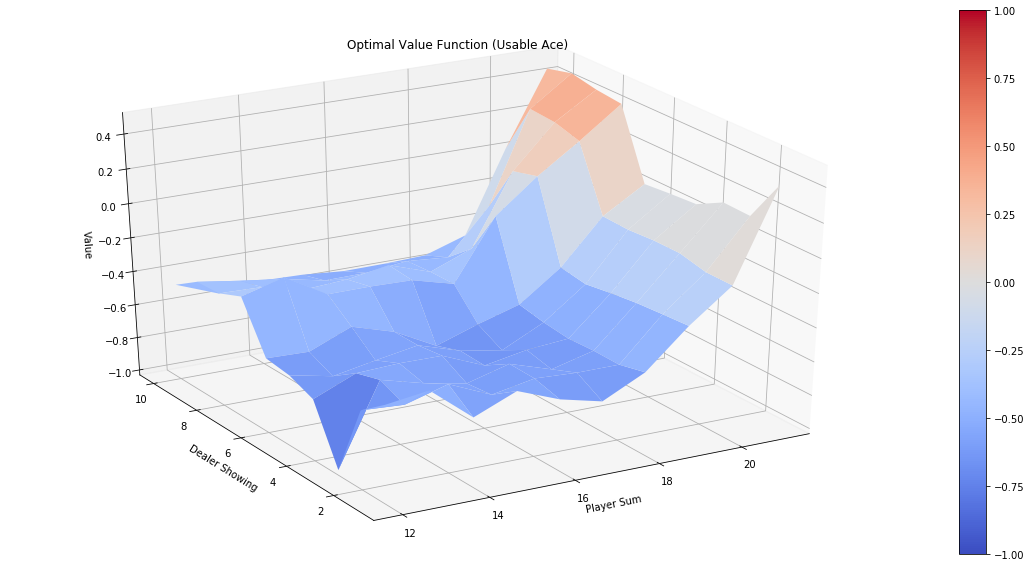

In [79]:
V = defaultdict(float)
for state, actions in q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")

In [80]:
blckjck = blackjack_game()
blckjck._reset()

(16, 1, 0)

In [128]:
q_, p_ = mc.state_action_MC_control(500000, .1)

In [157]:
s_ = blckjck._reset()
for i in range(100):
    pi = p_(s_)
    action_choice = np.argmax(pi)
    new_state, reward, over, _ = blckjck._step(action_choice)
    print(blckjck.render(action_choice))
    if over:
        break
    state = new_state

[['Player points: ' '20' 'Player action: ' '1']
 ['Dealer points: ' '17' 'Dealer action: ' '0']]
[['Player points: ' '25' 'Player action: ' '1']
 ['Dealer points: ' '17' 'Dealer action: ' '0']]
